In [2]:
import sys
print(sys.executable)

C:\Users\NIU\.conda\envs\gmeq\python.exe


In [4]:
from libpysal.weights import Queen
from esda.moran import Moran
print("Imports OK!")

Imports OK!


In [6]:
# Import core libraries
import geopandas as gpd          # For spatial data handling (shapefiles, geometries)
import pandas as pd             # For tabular data (Excel, CSV)
import numpy as np              # For numerical operations
import matplotlib.pyplot as plt # For plotting

# Import spatial statistics tools
from libpysal.weights import Queen   # For spatial weights (Queen contiguity)
from esda.moran import Moran         # For Global Moran's I


In [12]:
# Read LSOA boundary file (shapefile or geopackage)
# TODO: change the file path and filename to your actual LSOA boundary data
g_lsoa = gpd.read_file(r"LSOA_data.shp")

# Read the CSV file containing mean indicators (LSOA_mean.csv)
# Use read_csv because the file extension is .csv
df_mean = pd.read_csv(r"LSOA_mean.csv")    

# Check the first few rows to confirm field (column) names
display(df_mean.head())
display(g_lsoa.head())


,LSOA21CD,NQPDE400,BtE400_mean,TPD400,NQPDE800,BtE800_mean,TPD800,NQPDE1200,BtE1200_mean,TPD1200,NQPDE2000,BtE2000_mean,TPD2000
0,E01005536,0.000842,0.333333,1.0,0.000842,0.333333,1.000000,0.000842,0.333333,1.000000,0.001873,2.333333,0.425668
1,E01004934,0.002356,0.333333,1.0,0.003782,1.333333,0.750000,0.007711,5.333334,0.801191,0.014669,19.333338,0.880719
2,E01006321,0.002008,0.333333,1.0,0.004593,2.333333,0.493590,0.011870,9.333333,0.934314,0.018529,43.333332,1.257097
3,E01005202,0.002525,0.333333,1.0,0.008160,4.333333,0.515018,0.023338,19.333334,1.058376,0.037165,175.333328,0.956565
4,E01005879,0.003330,0.333333,1.0,0.008097,3.333333,1.083333,0.009970,5.333333,1.183333,0.010728,12.333334,1.000000


,LSOA21CD,LSOA21NM,NQPDE400,BtE400,TPD400,NQPDE800,BtE800,TPD800,NQPDE1200,BtE1200,TPD1200,NQPDE2000,BtE2000,TPD2000,Shape_Leng,Shape_Area,geometry
0,E01005536,Rochdale 021E,0.000842,0.333333,1.0,0.000842,0.333333,1.000000,0.000842,0.333333,1.000000,0.001873,2.333333,0.425668,4003.082680,3.321585e+05,"POLYGON ((387604.835 407233.927, 387672.688 40..."
1,E01004934,Bolton 035B,0.002356,0.333333,1.0,0.003782,1.333333,0.750000,0.007711,5.333334,0.801191,0.014669,19.333338,0.880719,7359.061084,1.081024e+06,"POLYGON ((364858.571 404829.533, 364858.935 40..."
2,E01006321,Wigan 003G,0.002008,0.333333,1.0,0.004593,2.333333,0.493590,0.011870,9.333333,0.934314,0.018529,43.333332,1.257097,4074.355217,4.317800e+05,"POLYGON ((353071.001 409706.539, 353071.227 40..."
3,E01005202,Manchester 009A,0.002525,0.333333,1.0,0.008160,4.333333,0.515018,0.023338,19.333334,1.058376,0.037165,175.333328,0.956565,6672.901877,8.151340e+05,"POLYGON ((386555.906 401903, 386556.385 401895..."
4,E01005879,Stockport 020B,0.003330,0.333333,1.0,0.008097,3.333333,1.083333,0.009970,5.333333,1.183333,0.010728,12.333334,1.000000,3470.271809,2.186948e+05,"POLYGON ((395466.866 389136.382, 395493.258 38..."


In [14]:
# Define the common key field used to join the two datasets
# TODO: change "LSOA_code" to the actual column name that represents LSOA ID in BOTH datasets
key_lsoa = "LSOA21CD"

# Merge LSOA geometry with the mean indicators table
# This will create a GeoDataFrame 'g' that has geometry + mean values
g = g_lsoa.merge(df_mean, on=key_lsoa, how="inner")

# Print basic info to confirm the merge worked
print("Number of LSOAs after merge:", len(g))
print("Columns in merged GeoDataFrame:")
print(g.columns)


Number of LSOAs after merge: 1694
Columns in merged GeoDataFrame:
Index(['LSOA21CD', 'LSOA21NM', 'NQPDE400_x', 'BtE400', 'TPD400_x',
       'NQPDE800_x', 'BtE800', 'TPD800_x', 'NQPDE1200_x', 'BtE1200',
       'TPD1200_x', 'NQPDE2000_x', 'BtE2000', 'TPD2000_x', 'Shape_Leng',
       'Shape_Area', 'geometry', 'NQPDE400_y', 'BtE400_mean', 'TPD400_y',
       'NQPDE800_y', 'BtE800_mean', 'TPD800_y', 'NQPDE1200_y', 'BtE1200_mean',
       'TPD1200_y', 'NQPDE2000_y', 'BtE2000_mean', 'TPD2000_y'],
      dtype='object')


In [16]:
def gini_coefficient(x):
    """
    Compute the Gini coefficient for a 1D numeric array.
    Formula used (for discrete data):
        G = 1 + 1/n - 2 * sum(C_k) / (n * S)
    """
    x = np.array(x, dtype=float)          # to numpy array
    x = x[np.isfinite(x)]                 # remove NaN / inf
    x = x[x >= 0]                         # keep non-negative
    if len(x) == 0:
        return np.nan

    x_sorted = np.sort(x)                 # sort
    n = len(x_sorted)                     # number of obs
    S = x_sorted.sum()                    # total sum
    cumx = np.cumsum(x_sorted)            # cumulative sums

    gini = 1 + 1.0/n - 2.0 * np.sum(cumx) / (n * S)
    return gini


In [37]:
def calc_gini_moran_clean(gdf, col_name):
    """
    Calculate Gini coefficient and Moran's I with cleaned numeric outputs.
    """

    s = gdf[col_name].astype(float)
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    g_sub = gdf.loc[s.index].copy()

    w = Queen.from_dataframe(g_sub, use_index=False)
    w.transform = "r"

    y = s.values

    gini = gini_coefficient(y)
    moran = Moran(y, w)

    # moran.I is a float, but moran.z and moran.p_norm may appear as arrays (numpy object dtype)
    z_val = float(np.array(moran.z).flatten()[0])
    p_val = float(np.array(moran.p_norm).flatten()[0])

    return {
        "gini": float(gini),
        "moran_I": float(moran.I),
        "z_score": z_val,
        "p_value": p_val
    }

In [39]:
mean_cols = [
    # BTBE mean fields
    "BtE800_mean", "BtE400_mean", "BtE1200_mean", "BtE2000_mean",
    
    # TPD mean fields
    "TPD400_y", "TPD800_y", "TPD1200_y", "TPD2000_y",
    
    # NQPDE mean fields
    "NQPDE400_y", "NQPDE800_y", "NQPDE1200_y", "NQPDE2000_y",
]

print("Columns to analyze:", mean_cols)


Columns to analyze: ['BtE800_mean', 'BtE400_mean', 'BtE1200_mean', 'BtE2000_mean', 'TPD400_y', 'TPD800_y', 'TPD1200_y', 'TPD2000_y', 'NQPDE400_y', 'NQPDE800_y', 'NQPDE1200_y', 'NQPDE2000_y']


In [41]:
results = []

for col in mean_cols:
    if col not in g.columns:
        print(f"Warning: {col} not found. Skipping.")
        continue

    res = calc_gini_moran_clean(g, col)

    var_type = ''.join([c for c in col if not c.isdigit()]).replace("_mean","").replace("_y","")
    radius = ''.join([c for c in col if c.isdigit()])

    results.append({
        "column": col,
        "type": var_type,
        "radius_m": int(radius),
        "gini": round(res["gini"], 4),
        "moran_I": round(res["moran_I"], 4),
        "z_score": round(res["z_score"], 3),
        "p_value": float(f"{res['p_value']:.2e}")
    })

results_df = pd.DataFrame(results)
results_df

,column,type,radius_m,gini,moran_I,z_score,p_value
0,BtE800_mean,BtE,800,0.7296,0.3251,-0.352,1.600000e-98
1,BtE400_mean,BtE,400,0.6795,0.1313,-0.200,1.400000e-17
2,BtE1200_mean,BtE,1200,0.6942,0.4025,-0.430,7.970000e-150
3,BtE2000_mean,BtE,2000,0.6769,0.5364,-0.494,2.340000e-264
4,TPD400_y,TPD,400,0.0417,0.0450,0.217,3.160000e-03
5,TPD800_y,TPD,800,0.1131,0.1220,0.463,2.190000e-15
6,TPD1200_y,TPD,1200,0.1390,0.1908,0.609,3.390000e-35
7,TPD2000_y,TPD,2000,0.1498,0.3483,-1.910,8.660000e-113
8,NQPDE400_y,NQPDE,400,0.6787,0.0635,-0.163,3.370000e-05
9,NQPDE800_y,NQPDE,800,0.6526,0.1318,-0.277,1.090000e-17


In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off')

table = ax.table(
    cellText=results_df.values,
    colLabels=results_df.columns,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(8)
table.auto_set_column_width(col=list(range(len(results_df.columns))))

plt.savefig("Gini_Moran_results_clean.png", bbox_inches='tight', dpi=300)
plt.close()

print("Saved table as Gini_Moran_results_clean.png")


Saved table as Gini_Moran_results_clean.png


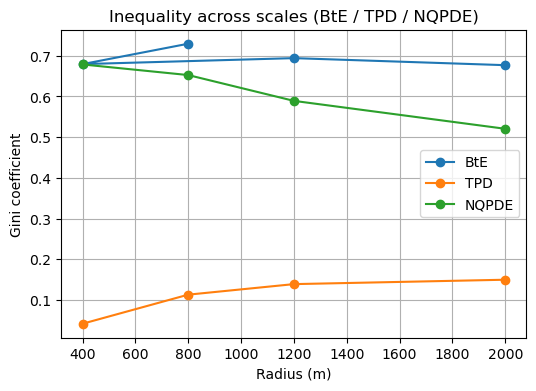

In [45]:
var_types = results_df['type'].unique()

plt.figure(figsize=(6,4))
for v in var_types:
    sub = results_df[results_df['type']==v]
    plt.plot(sub['radius_m'], sub['gini'], marker='o', label=v)

plt.xlabel("Radius (m)")
plt.ylabel("Gini coefficient")
plt.title("Inequality across scales (BtE / TPD / NQPDE)")
plt.legend()
plt.grid(True)
plt.savefig("Gini_multiscale.png", dpi=300)
plt.show()


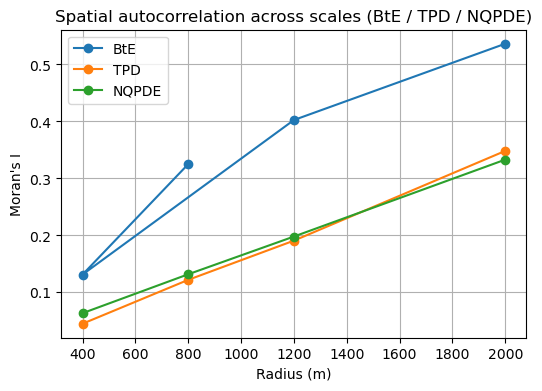

In [47]:
plt.figure(figsize=(6,4))
for v in var_types:
    sub = results_df[results_df['type']==v]
    plt.plot(sub['radius_m'], sub['moran_I'], marker='o', label=v)

plt.xlabel("Radius (m)")
plt.ylabel("Moran's I")
plt.title("Spatial autocorrelation across scales (BtE / TPD / NQPDE)")
plt.legend()
plt.grid(True)
plt.savefig("Moran_multiscale.png", dpi=300)
plt.show()

In [53]:
import sys
!"{sys.executable}" -m pip install seaborn

In [55]:
import seaborn as sns
sns.set_theme(style="whitegrid")

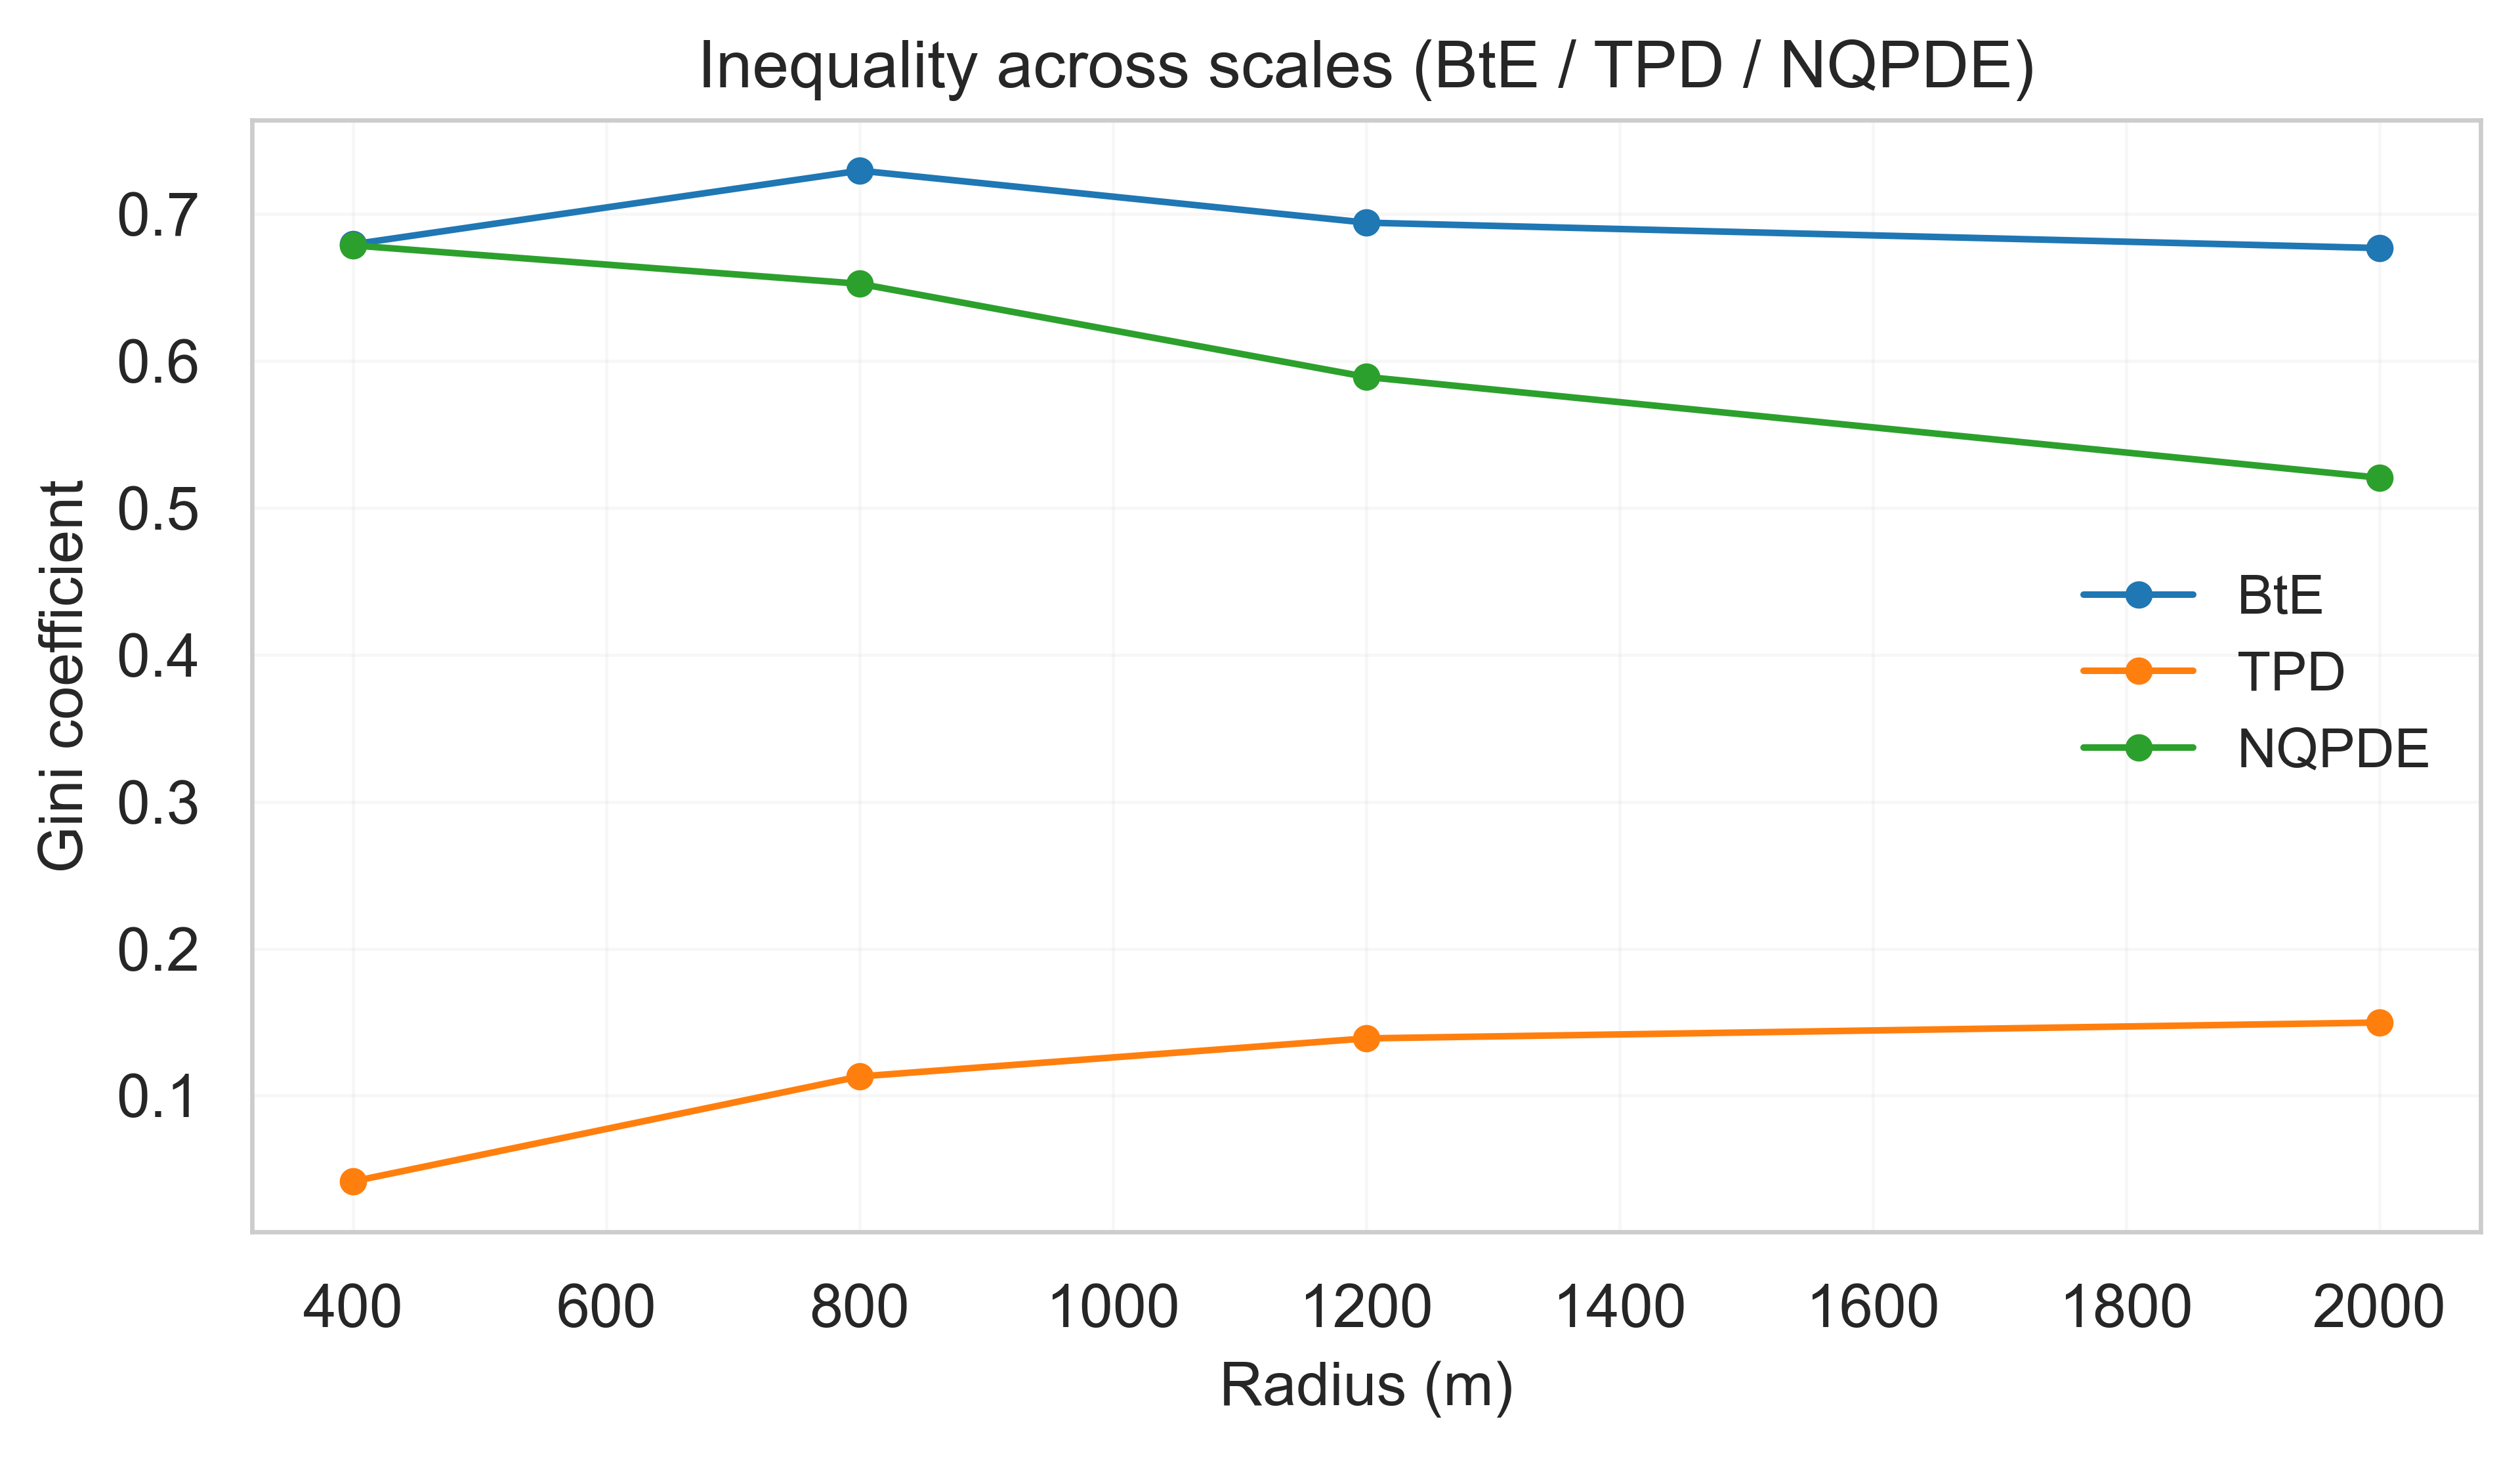

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# --- Minimal SCI style ---
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 10,
    "axes.linewidth": 0.8,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
})

fig, ax = plt.subplots(figsize=(6.5, 3.8), dpi=600)

colors = {
    "BtE": "#1f77b4",
    "TPD": "#ff7f0e",
    "NQPDE": "#2ca02c"
}

# Draw faint grid
ax.grid(True, linewidth=0.6, alpha=0.15)

# Plot each variable type
for v in results_df['type'].unique():
    sub = results_df[results_df['type']==v].sort_values("radius_m")
    ax.plot(
        sub['radius_m'],
        sub['gini'],
        label=v,
        linewidth=1.2,
        marker='o',
        markersize=4,
        color=colors[v]
    )

# Axis labels & title
ax.set_xlabel("Radius (m)", fontsize=11)
ax.set_ylabel("Gini coefficient", fontsize=11)
ax.set_title("Inequality across scales (BtE / TPD / NQPDE)", fontsize=12)

# Clean legend
ax.legend(frameon=False, fontsize=10)

plt.tight_layout()
plt.savefig("SCI_style_Gini_curve.png", dpi=600, bbox_inches="tight")
plt.show()


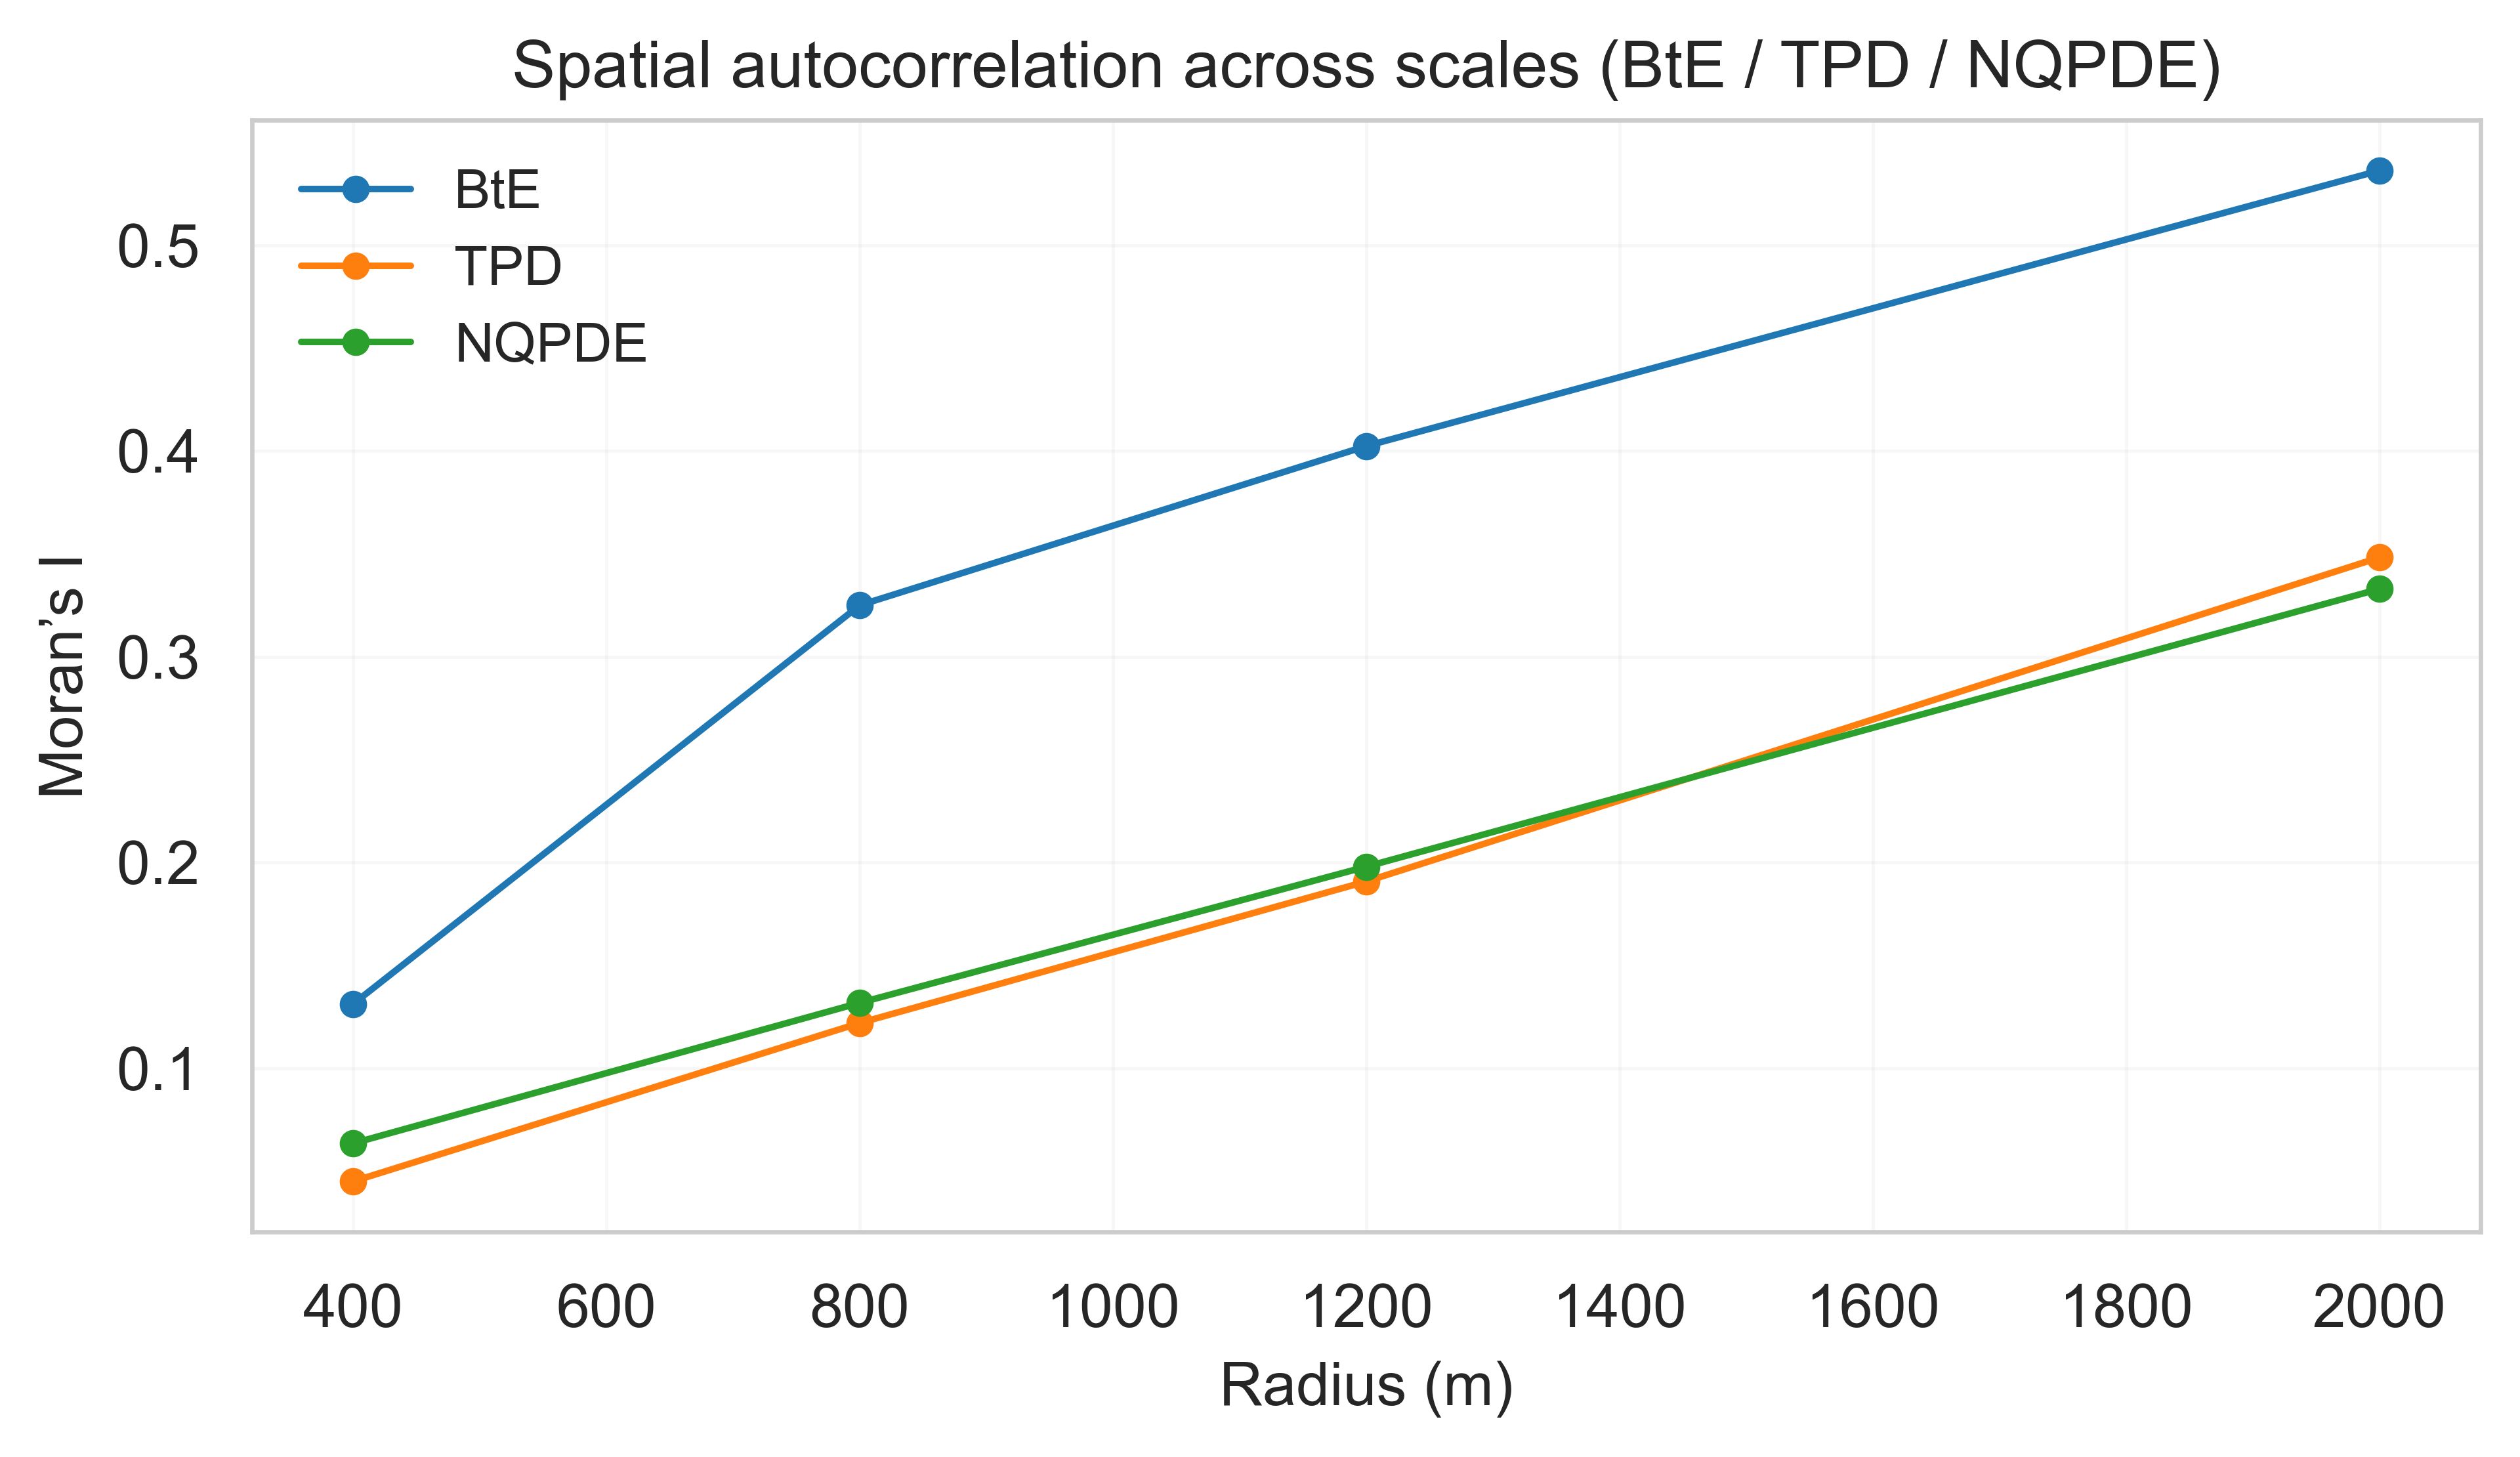

In [67]:
fig, ax = plt.subplots(figsize=(6.5, 3.8), dpi=600)

# Faint grid
ax.grid(True, linewidth=0.6, alpha=0.15)

for v in results_df['type'].unique():
    sub = results_df[results_df['type']==v].sort_values("radius_m")
    ax.plot(
        sub['radius_m'],
        sub['moran_I'],
        label=v,
        linewidth=1.2,
        marker='o',
        markersize=4,
        color=colors[v]
    )

ax.set_xlabel("Radius (m)", fontsize=11)
ax.set_ylabel("Moran’s I", fontsize=11)
ax.set_title("Spatial autocorrelation across scales (BtE / TPD / NQPDE)", fontsize=12)

ax.legend(frameon=False, fontsize=10)

plt.tight_layout()
plt.savefig("SCI_style_Moran_curve.png", dpi=600, bbox_inches="tight")
plt.show()


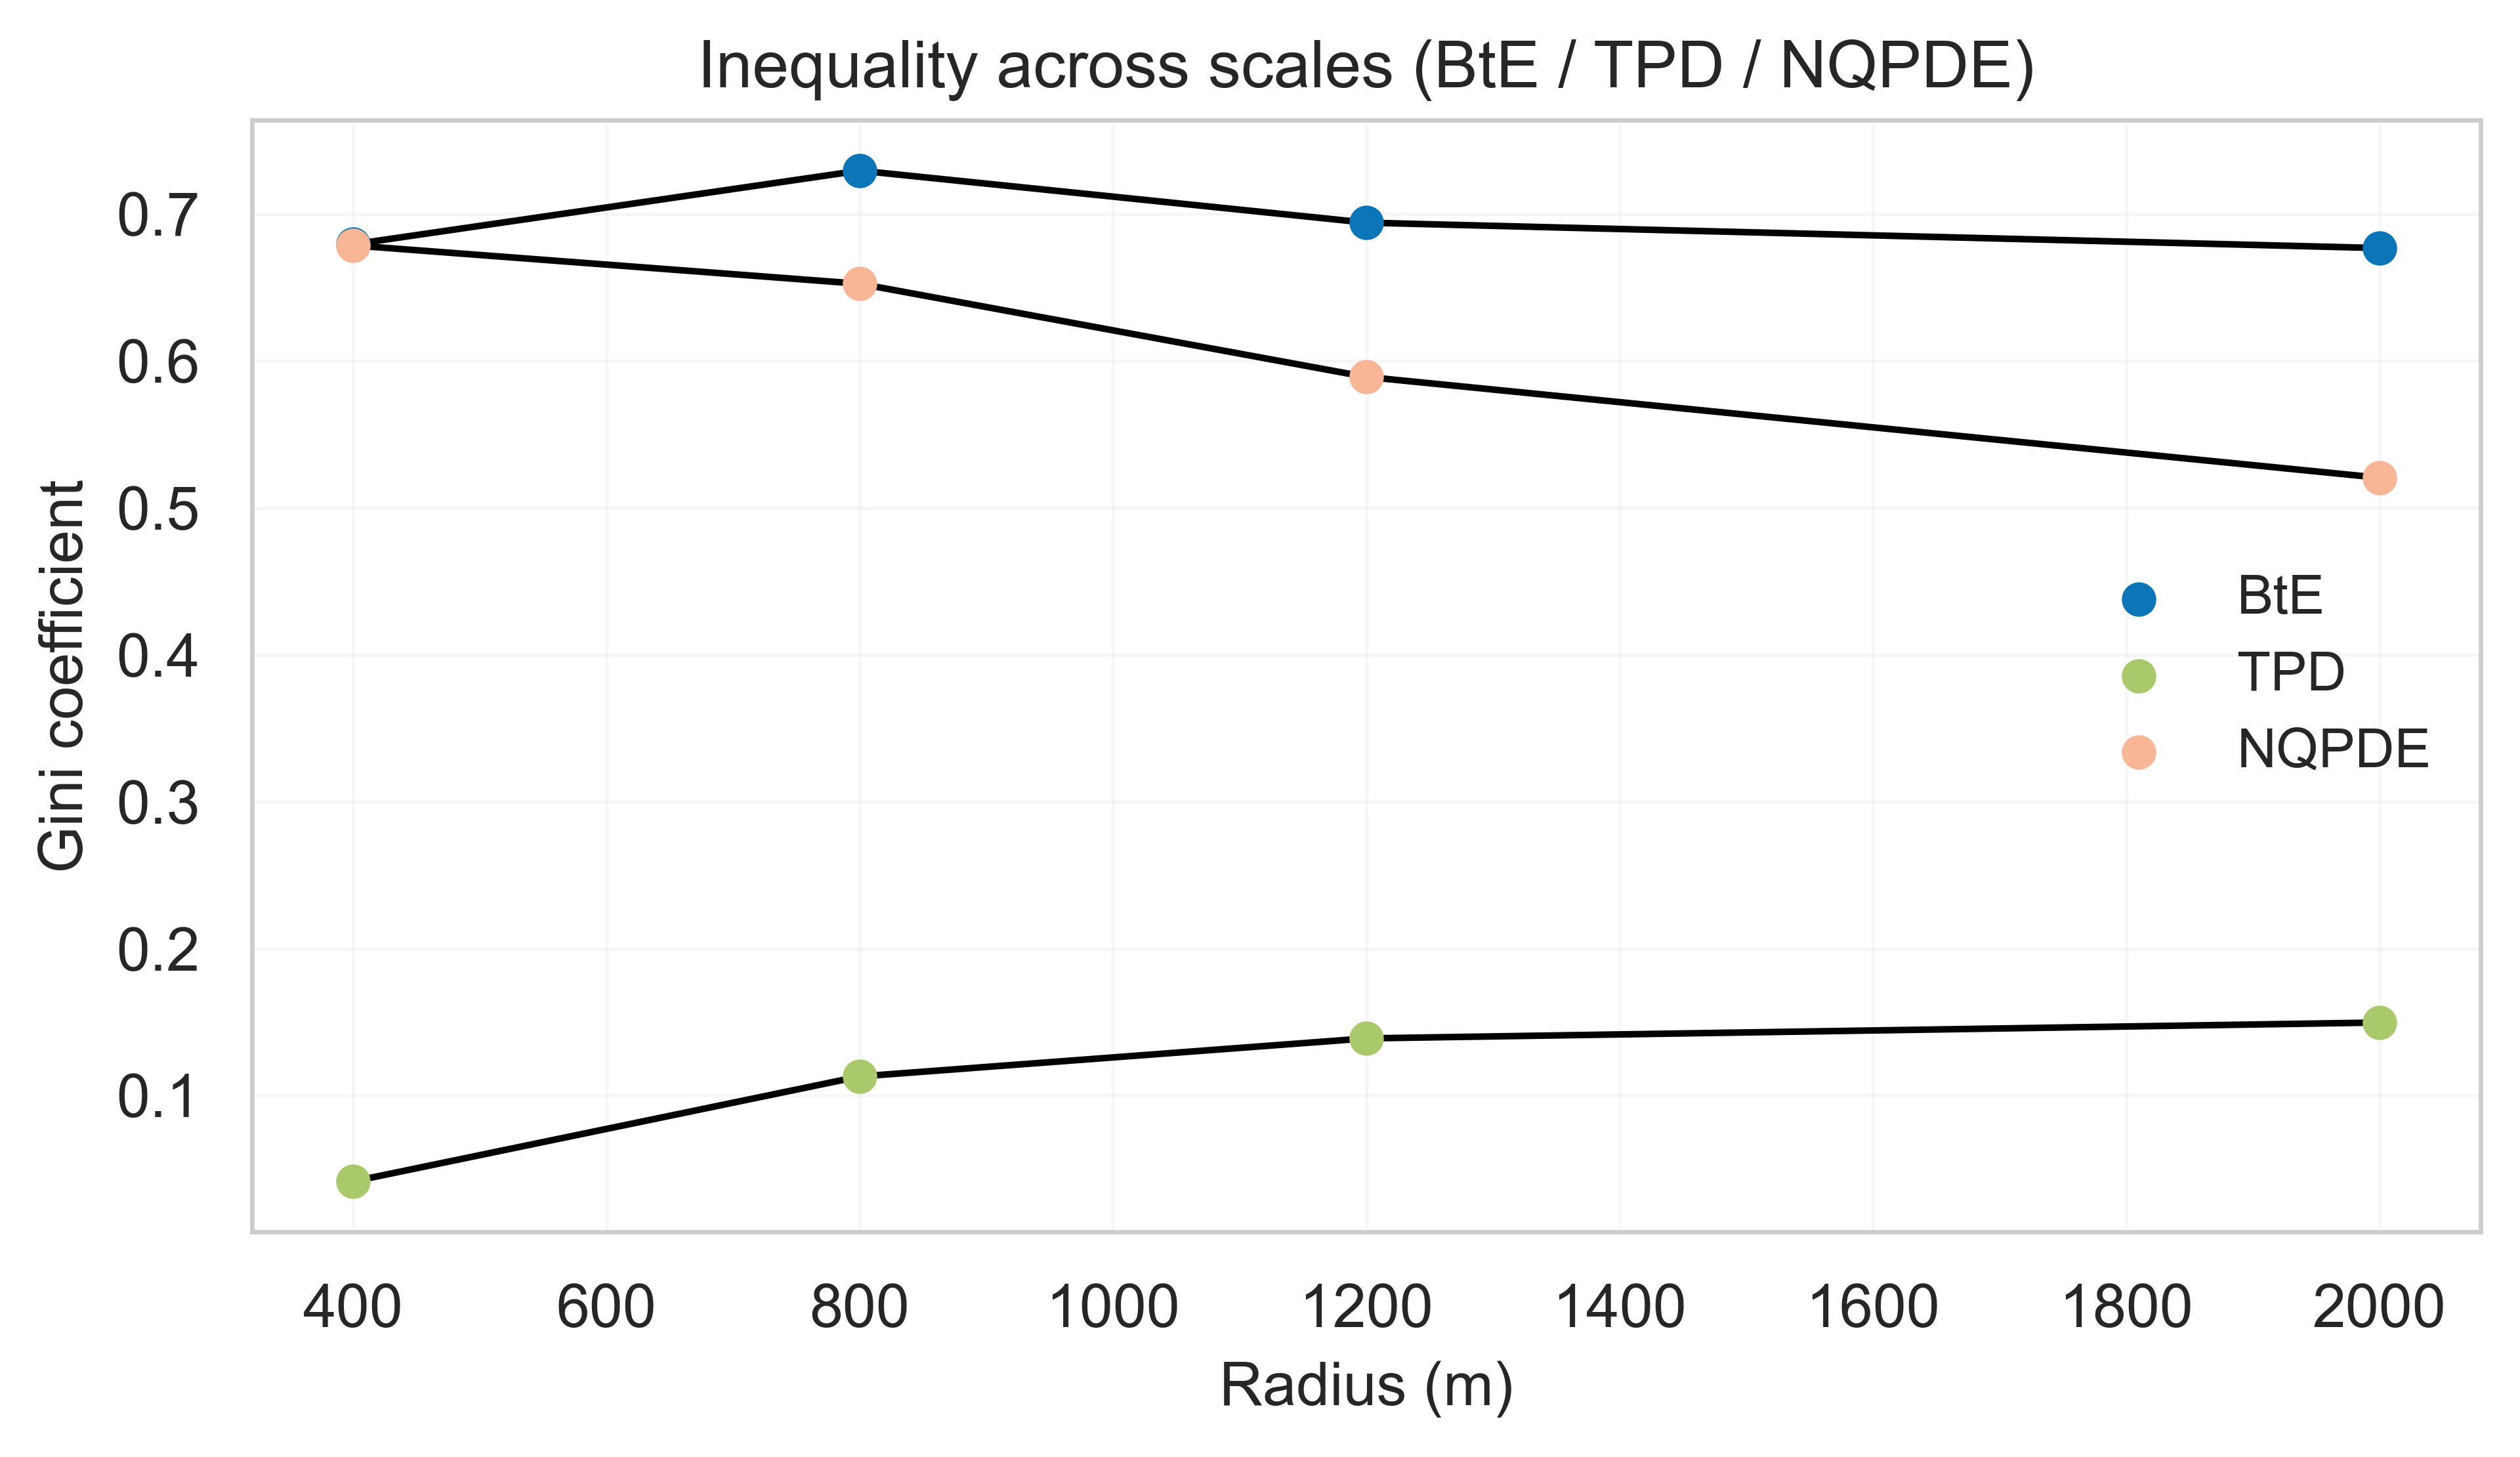

In [69]:
import matplotlib.pyplot as plt

# === SCI minimal style ===
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 10,
    "axes.linewidth": 0.8,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
})

# Your palette
color_palette = [
    "#0B76B7",  # 蓝
    "#BBB6DE",  # 淡紫
    "#A9C96B",  # 绿
    "#F8B697",  # 橙
    "#C1122E",  # 红
]

# Map variable type to color
type_colors = {
    "BtE": color_palette[0],
    "TPD": color_palette[2],
    "NQPDE": color_palette[3],
}

fig, ax = plt.subplots(figsize=(6.5, 3.8), dpi=600)

# Faint grid
ax.grid(True, linewidth=0.6, alpha=0.15)

for v in results_df['type'].unique():
    sub = results_df[results_df['type']==v].sort_values("radius_m")

    # --- BLACK LINE ---
    ax.plot(
        sub['radius_m'],
        sub['gini'],
        color="black",
        linewidth=1.2,
        zorder=1
    )

    # --- COLORED MARKERS ---
    ax.scatter(
        sub['radius_m'],
        sub['gini'],
        color=type_colors[v],
        s=28,
        label=v,
        zorder=2
    )

ax.set_xlabel("Radius (m)", fontsize=11)
ax.set_ylabel("Gini coefficient", fontsize=11)
ax.set_title("Inequality across scales (BtE / TPD / NQPDE)", fontsize=12)

ax.legend(frameon=False, fontsize=10)

plt.tight_layout()
plt.savefig("SCI_style_Gini_blackline_colorpoints.png", dpi=600, bbox_inches="tight")
plt.show()


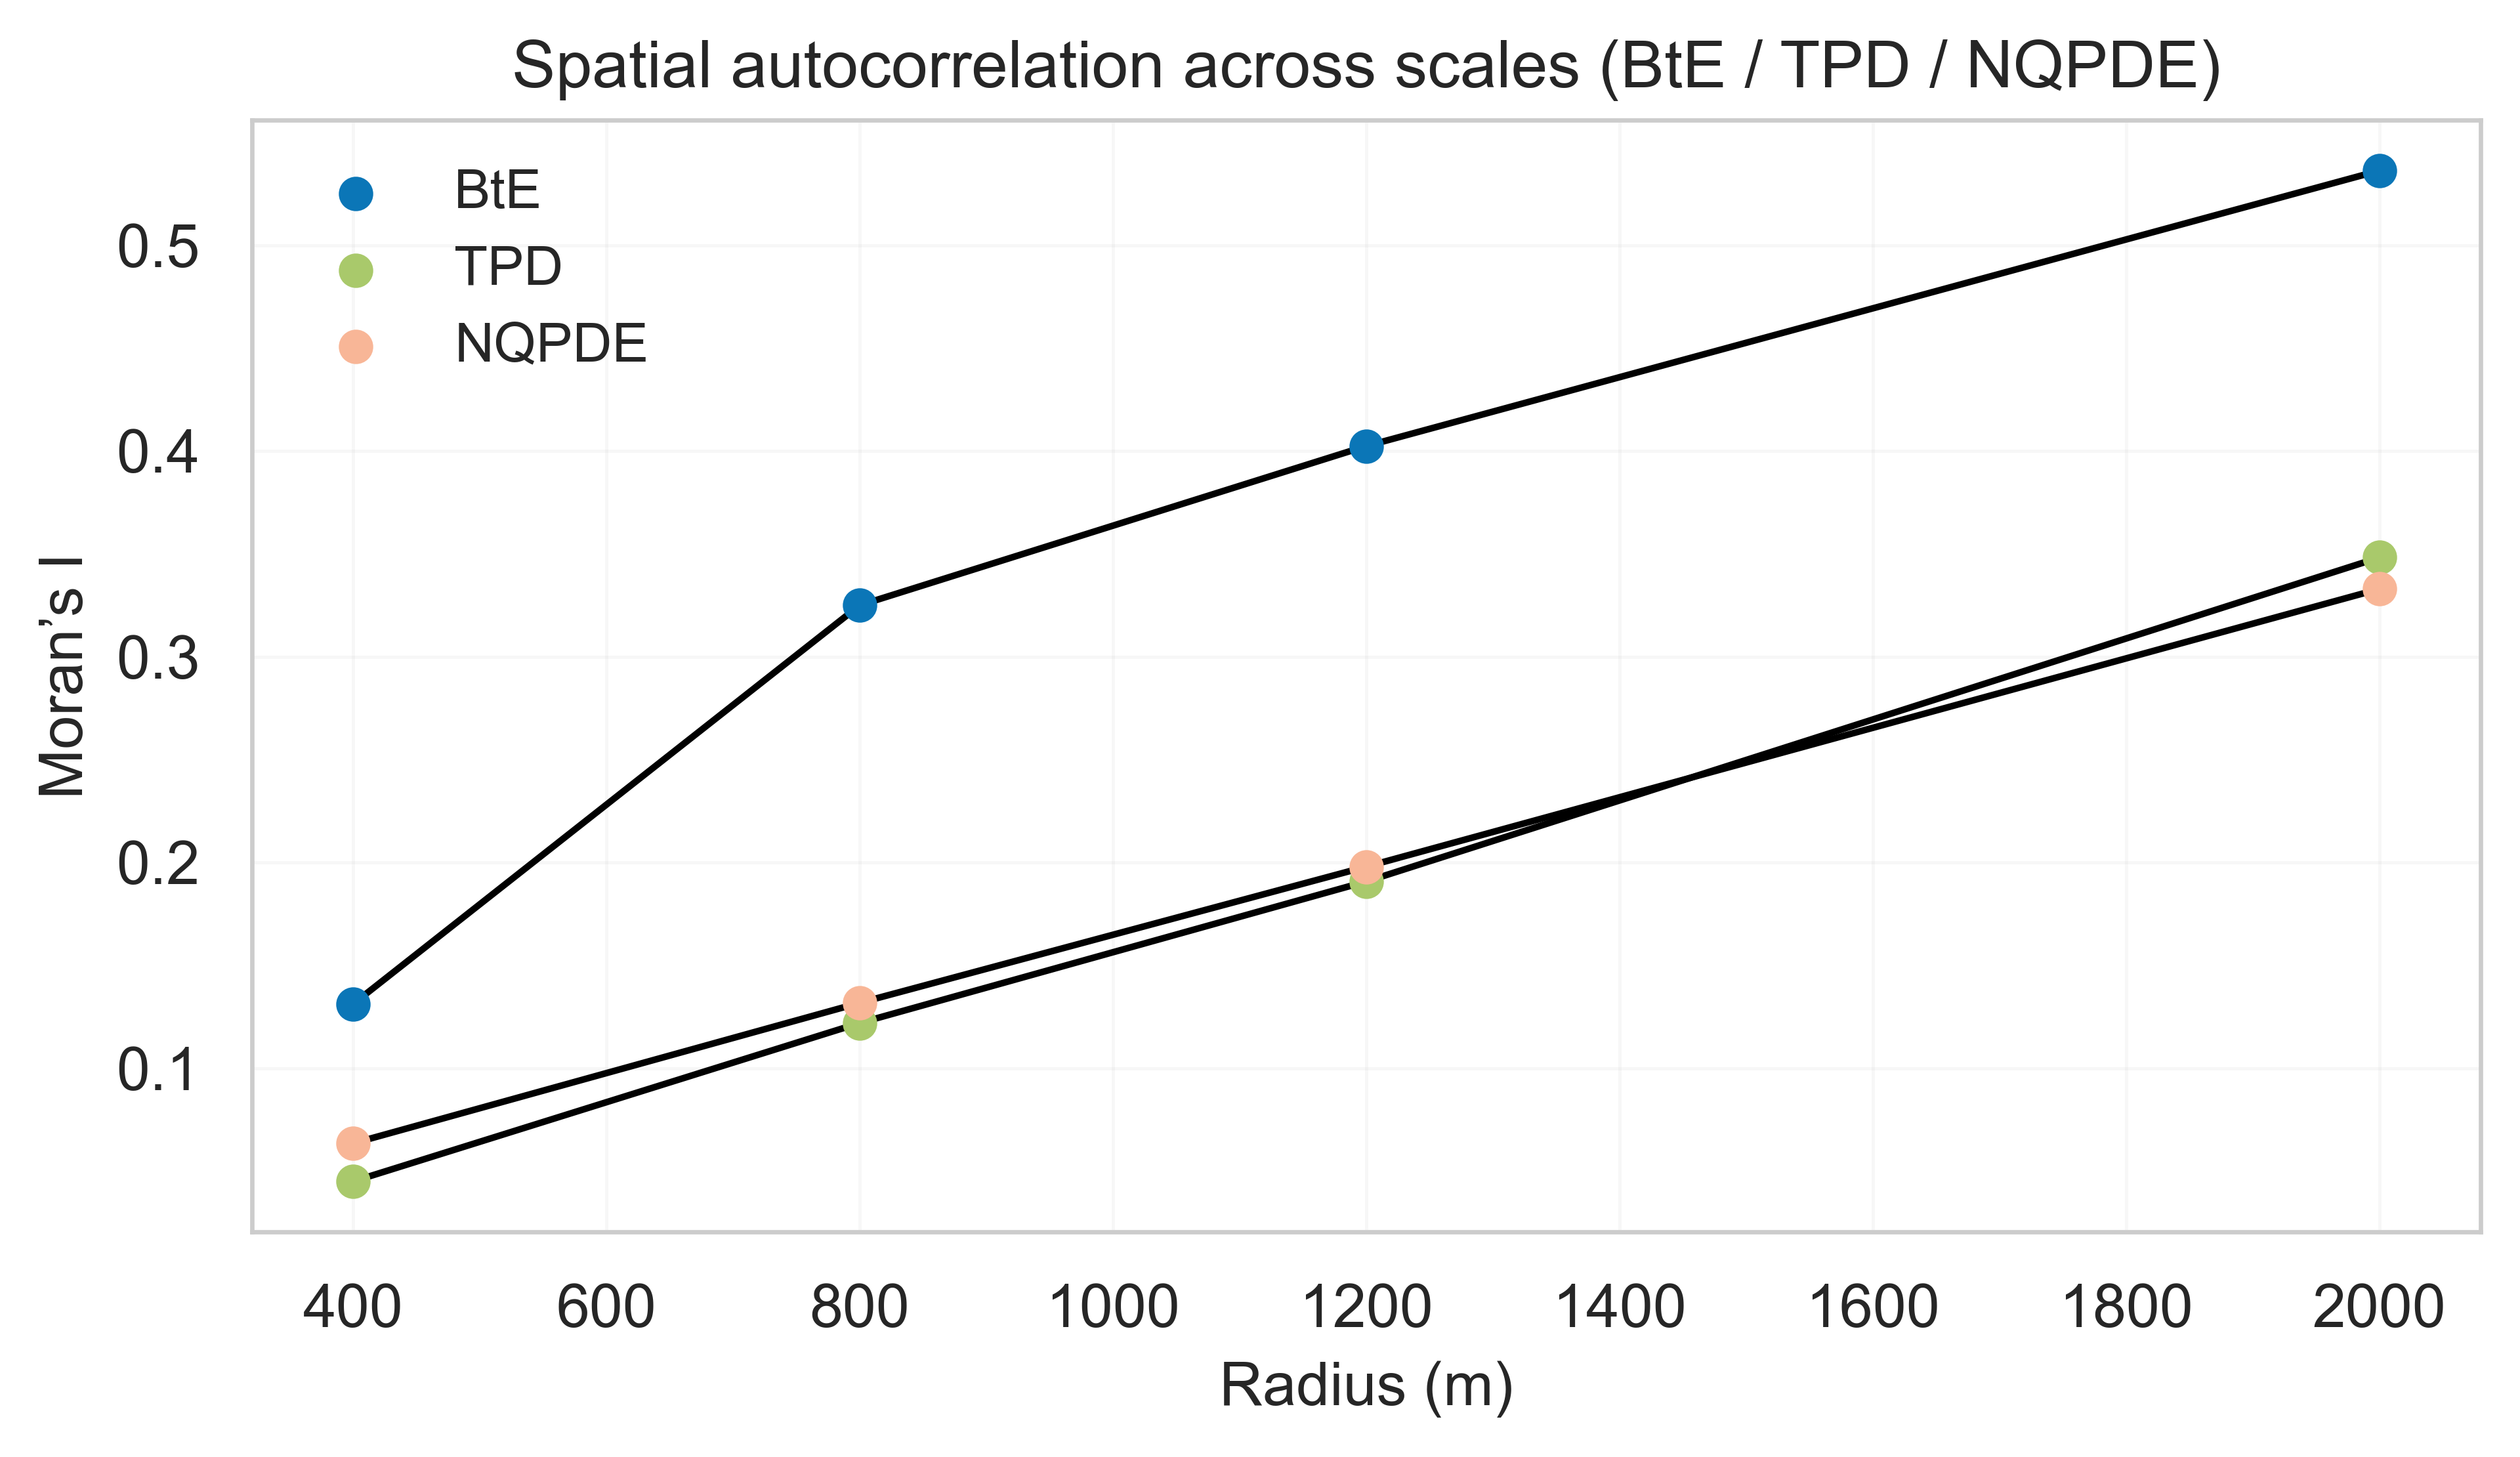

In [71]:
fig, ax = plt.subplots(figsize=(6.5, 3.8), dpi=600)

ax.grid(True, linewidth=0.6, alpha=0.15)

for v in results_df['type'].unique():
    sub = results_df[results_df['type']==v].sort_values("radius_m")

    # Black line
    ax.plot(
        sub['radius_m'],
        sub['moran_I'],
        color="black",
        linewidth=1.2,
        zorder=1
    )

    # Colored turning points
    ax.scatter(
        sub['radius_m'],
        sub['moran_I'],
        color=type_colors[v],
        s=28,
        label=v,
        zorder=2
    )

ax.set_xlabel("Radius (m)", fontsize=11)
ax.set_ylabel("Moran’s I", fontsize=11)
ax.set_title("Spatial autocorrelation across scales (BtE / TPD / NQPDE)", fontsize=12)

ax.legend(frameon=False, fontsize=10)

plt.tight_layout()
plt.savefig("SCI_style_Moran_blackline_colorpoints.png", dpi=600, bbox_inches="tight")
plt.show()
